<a href="https://colab.research.google.com/github/Ahmedtambal/Malaria-Detection-using-CNN-Graduation-project/blob/main/Malaria_Detection_using_CNN_Graduation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import misc
import imageio
import os
import matplotlib.pyplot as plt
from os import listdir
import random

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_datasets.core import dataset_info
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
#creating figures
import matplotlib.pyplot as plt
import seaborn as sns

#resizing
import cv2
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for GPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.9.2
Hub version: 0.12.0
GPU available (YESS!!!!)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

base_path = "/content/drive/MyDrive/cell-images-for-detecting-malaria/Training"
test_path = "/content/drive/MyDrive/ME/Cells"


In [ ]:
IMG_SHAPE = 50

cell_labels = []

# cells
cell_images = []

#first six infected and unfected cells for visualization only
infected_cells = []
uninfected_cells = []



In [ ]:
infected_path = base_path +'/Parasitized/'
for file in listdir(infected_path):
   if file.endswith('.png'):
        file_path = infected_path + file
        image = imageio.imread(file_path)
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0
        infected_cells.append(image)
        cell_images.append(image)
        cell_labels.append(1)


In [ ]:
#get uninfected cells
uninfected_path = base_path +'/Uninfected/'
for file in listdir(uninfected_path):
    if file.endswith('.png'):
        file_path = uninfected_path + file
        image = imageio.imread(file_path)
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0
        uninfected_cells.append(image)
        cell_images.append(image)
        cell_labels.append(0)

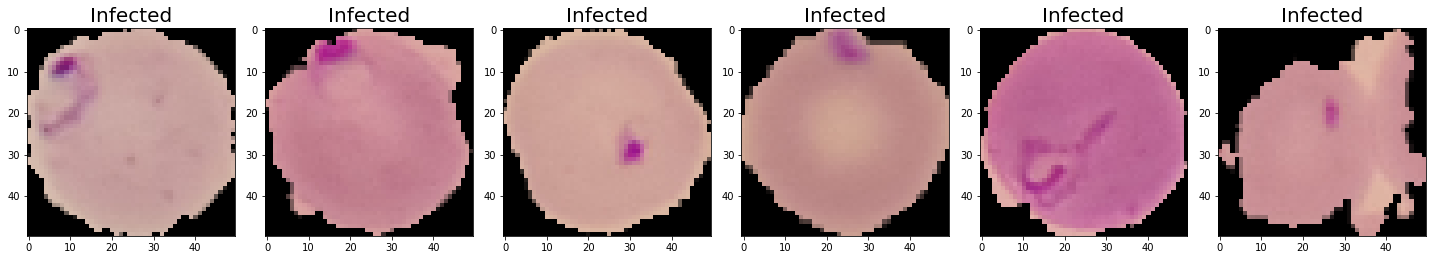

<Figure size 432x288 with 0 Axes>

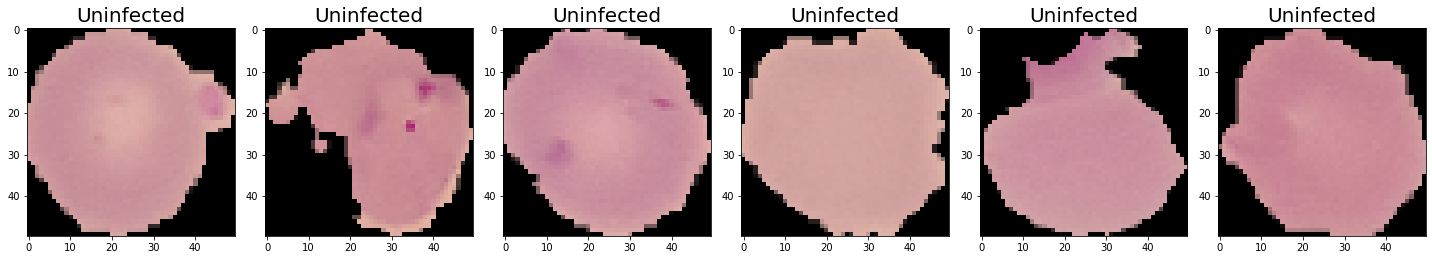

In [ ]:
# visualize cells
def ShowFirstSix(images_arr,title):

    fig, axes = plt.subplots(1, 6, figsize=(20,20))

    for img, ax in zip( images_arr, axes):
        ax.imshow(img)

        ax.set_title(title,fontsize=20)
    plt.tight_layout()

    plt.savefig("/content/sample_data/output34.png")

    plt.show()



ShowFirstSix(infected_cells,'Infected' )
plt.savefig("/content/sample_data/output35.png")

ShowFirstSix(uninfected_cells,'Uninfected')




In [ ]:
#randomly shuffle cell image list and their labels
def reorder(old_list,order):
    new_list = []
    for i in order:
        new_list.append(old_list[i])
    return new_list

np.random.seed(seed=42)
indices = np.arange(len(cell_labels))
np.random.shuffle(indices)
indices = indices.tolist()
cell_labels = reorder(cell_labels,indices)
cell_images = reorder(cell_images,indices)

#change to arrays
image_array = np.array(cell_images)
label_array = np.array(cell_labels)

In [ ]:
print(f'Total Parasitized images {len(os.listdir(os.path.join(base_path, "Parasitized")))}')
print(f'Total Uninfected images {len(os.listdir(os.path.join(base_path, "Uninfected")))}')

Total Parasitized images 13082
Total Uninfected images 13800


In [ ]:
# 70% of the data goes to the training data set
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, train_size=0.70, random_state=100)

# 30% additional data goes to the validation data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=len(y_test), random_state=100)

print("size of training data set {}".format((X_train.shape[0])))
print("size of validating data set {}".format(X_val.shape[0]))
print("size of testing data set {}".format(X_test.shape[0]))


size of training data set 10752
size of validating data set 8064
size of testing data set 8064


In [ ]:
#seeding random seed so I can get consist results
tf.random.set_seed(10)

model =  Sequential([

    #convolutional layers
    Conv2D(32, (3,3), activation='relu', input_shape=(50,50, 3),padding='same'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3),activation ='relu',padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu',padding='same'),
    MaxPooling2D(2,2),

    # dense layer
    Flatten(),
    Dropout(0.50),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.binary_accuracy])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [early_stop, log_csv]

epochs = 20
batch_size =  600
history = model.fit(X_train,y_train,
    steps_per_epoch=int(np.ceil(len(y_train)/ float(batch_size))),
    epochs=epochs,
    validation_data=(X_val,y_val),
    validation_steps=int(np.ceil(len(y_val) / float(batch_size))),
    callbacks=callbacks_list
)

Epoch 1/20
18/18 [==============================] - 11s 59ms/step - loss: 0.6974 - binary_accuracy: 0.5174 - val_loss: 0.6785 - val_binary_accuracy: 0.6179
Epoch 2/20
18/18 [==============================] - 0s 23ms/step - loss: 0.6656 - binary_accuracy: 0.6020 - val_loss: 0.6585 - val_binary_accuracy: 0.5880
Epoch 3/20
18/18 [==============================] - 0s 22ms/step - loss: 0.6348 - binary_accuracy: 0.6359 - val_loss: 0.6165 - val_binary_accuracy: 0.6592
Epoch 4/20
18/18 [==============================] - 0s 22ms/step - loss: 0.5979 - binary_accuracy: 0.6828 - val_loss: 0.6088 - val_binary_accuracy: 0.6706
Epoch 5/20
18/18 [==============================] - 0s 22ms/step - loss: 0.5649 - binary_accuracy: 0.7096 - val_loss: 0.5396 - val_binary_accuracy: 0.7634
Epoch 6/20
18/18 [==============================] - 0s 22ms/step - loss: 0.5216 - binary_accuracy: 0.7467 - val_loss: 0.4812 - val_binary_accuracy: 0.7884
Epoch 7/20
18/18 [==============================] - 0s 22ms/step - lo

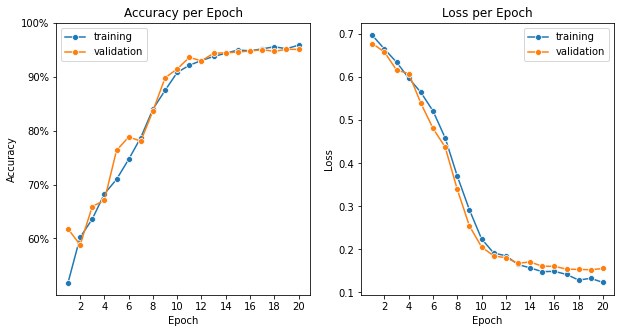

In [ ]:
 #Plot accuracy and loss per epoch

#accuracy
train_accuracy = history.history['binary_accuracy']
validation_accuracy = history.history['val_binary_accuracy']

#loss
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

epoch_range = range(1,len(train_accuracy)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

#accuracy
ax[0].set_title('Accuracy per Epoch')
sns.lineplot(x=epoch_range,y=train_accuracy,marker='o',ax=ax[0])
sns.lineplot(x=epoch_range,y=validation_accuracy,marker='o',ax=ax[0])
ax[0].legend(['training','validation'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks([2,4,6,8,10,12,14,16,18,20])
ax[0].set_yticks([.6,.7,.8,.9,1.0])
ax[0].set_yticklabels(['60%','70%','80%','90%','100%'])
#loss
ax[1].set_title('Loss per Epoch')
sns.lineplot(x=epoch_range,y=train_loss,marker='o',ax=ax[1])
sns.lineplot(x=epoch_range,y=validation_loss,marker='o',ax=ax[1])
ax[1].legend(['training','validation'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks([2,4,6,8,10,12,14,16,18,20])
plt.plot()
plt.savefig("likh.png")

In [ ]:
accuracy = model.evaluate(X_train , y_train)
print("Accuracy: ",accuracy)

336/336 [==============================] - 1s 3ms/step - loss: 0.1098 - binary_accuracy: 0.9621
Accuracy:  [0.10978104919195175, 0.9620535969734192]


In [ ]:
y_pred = model.predict(X_test)


252/252 [==============================] - 1s 2ms/step


252/252 [==============================] - 1s 2ms/step
The result of TF rate and TP rate is = (0.32930131792742373, 0.3583349319010167)
252/252 [==============================] - 1s 3ms/step - loss: 0.1549 - binary_accuracy: 0.9494


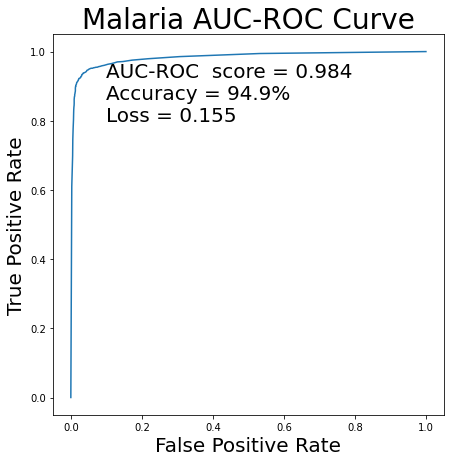

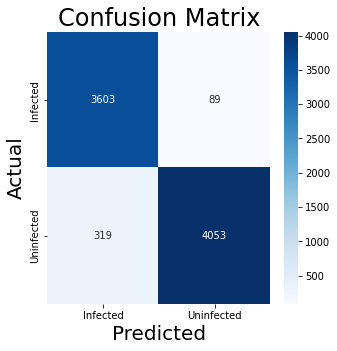

In [ ]:
def GetFalseTruePositiveRate(y_true,y_prob,threshold):

    y_predict = np.fromiter([1 if x > threshold else 0 for x in y_prob ],int)
    n_positives = y_true.sum()
    n_negatives = y_true.shape[0] - n_positives

    # get n true positives
    n_true_pos = 0
    n_false_pos = 0
    for pred_value,true_value in zip(y_predict,y_true):
        # true positive
        if true_value == 1 and pred_value == 1:
            n_true_pos += 1
        # false positive
        elif true_value == 0 and pred_value == 1:
            n_false_pos += 1
    true_pos_rate = n_true_pos/n_positives
    false_pos_rate = n_false_pos/n_negatives
    return false_pos_rate,true_pos_rate

y_true = y_train
y_prob = model.predict(X_test)
results =GetFalseTruePositiveRate(y_true,y_prob,0.5)
print('The result of TF rate and TP rate is =' ,results)



def MakeConfusionMatrix(y_true,y_prob,threshold):
    confusion_matrix = np.array([[0,0],[0,0]])
    for pred_value,true_value in zip(y_prob,y_true):
        if true_value == 1:
            #true positive
            if pred_value > threshold:
                confusion_matrix[0,0] += 1
            #false negative
            else:
                confusion_matrix[1,0] += 1
        else:
            #false positive
            if pred_value > threshold:
                 confusion_matrix[0,1] += 1
            #true negative
            else:
                confusion_matrix[1,1] += 1
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix,ax=ax,cmap='Blues',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title('Confusion Matrix',fontsize=24)
    plt.show()

y_predict = model.predict(X_test)
thresholds = np.arange(0.01,1.01,0.01)
thresholds = np.append(np.array([0,0.00001,0.0001,0.001]),thresholds)
roc_auc = np.array([GetFalseTruePositiveRate(y_test,y_predict,n) for n in thresholds ])
roc_auc = np.sort(roc_auc,axis=0)
roc_auc_value = roc_auc_score(y_test,y_predict)
loss,accuracy = model.evaluate(X_test,y_test)
accuracy = accuracy
loss = loss
text = 'AUC-ROC  score = {:.3f}'.format(roc_auc_value)
text += '\nAccuracy = {:.1f}%'.format(accuracy*100)
text += '\nLoss = {:.3f}'.format(loss)

fig = plt.figure(figsize=(7,7))
ax =  fig.gca()
ax.set_title('Malaria AUC-ROC Curve',fontsize=28)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.plot(roc_auc[:,0],roc_auc[:,1])
ax.text(s=text,x=0.1, y=0.8,fontsize=20)
plt.show()

MakeConfusionMatrix(y_test,y_predict,0.5)

In [ ]:
import sklearn.metrics
precision = sklearn.metrics.precision_score(y_test,( y_pred > 0.5 ))
F1 = sklearn.metrics.f1_score(y_test,( y_pred > 0.5 ))
recall = sklearn.metrics.recall_score(y_test,( y_pred > 0.5 ))
Accuracy = sklearn.metrics.accuracy_score(y_test,( y_pred > 0.5 ))

print('Accuracy score is : ' ,Accuracy )
print('Precision score is : ' ,precision )
print('F1 score is : ' ,F1 )
print('Recall score is : ' ,recall )


Accuracy score is :  0.9494047619047619
Precision score is :  0.9758938244853738
F1 score is :  0.946414499605989
Recall score is :  0.9186639469658338


The following test image is of Parasitized Cell with label '1'


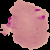

In [ ]:
import keras.preprocessing.image
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
test_image= "/content/drive/MyDrive/ME/Cells/Parasitized/C99P60ThinF_IMG_20150918_142334_cell_46.png"
test_image= load_img(test_image,target_size=(50 , 50))
print("The following test image is of Parasitized Cell with label '1'")
test_image

In [ ]:
test_image= img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)

(1, 50, 50, 3)


In [ ]:
model.predict(test_image)

1/1 [==============================] - 0s 16ms/step


array([[1.]], dtype=float32)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
image_shape = [50,50]
vgg19 = VGG19(input_shape=(image_shape[0], image_shape[1], 3),
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = tf.keras.layers.Flatten()(vgg19.output)
output = Dense(1, activation='sigmoid')(x)

VGG = Model(inputs = vgg19.input, outputs = output)


80134624/80134624 [==============================] - 4s 0us/step


In [ ]:
# Compile the model
VGG.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.binary_accuracy])
VGG.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [early_stop, log_csv]

epochs = 20
batch_size = 32
his = VGG.fit(X_train,y_train,
    steps_per_epoch=int(np.ceil(len(y_train)/ float(batch_size))),
    epochs=epochs,
    validation_data=(X_val,y_val),
    validation_steps=int(np.ceil(len(y_val) / float(batch_size))),
    callbacks=callbacks_list
)

Epoch 1/20
336/336 [==============================] - 14s 21ms/step - loss: 0.5480 - binary_accuracy: 0.7474 - val_loss: 0.4463 - val_binary_accuracy: 0.8285
Epoch 2/20
336/336 [==============================] - 6s 19ms/step - loss: 0.4059 - binary_accuracy: 0.8435 - val_loss: 0.3833 - val_binary_accuracy: 0.8392
Epoch 3/20
336/336 [==============================] - 6s 19ms/step - loss: 0.3597 - binary_accuracy: 0.8604 - val_loss: 0.3475 - val_binary_accuracy: 0.8625
Epoch 4/20
336/336 [==============================] - 6s 19ms/step - loss: 0.3375 - binary_accuracy: 0.8661 - val_loss: 0.3311 - val_binary_accuracy: 0.8641
Epoch 5/20
336/336 [==============================] - 6s 19ms/step - loss: 0.3232 - binary_accuracy: 0.8720 - val_loss: 0.3225 - val_binary_accuracy: 0.8704
Epoch 6/20
336/336 [==============================] - 6s 19ms/step - loss: 0.3135 - binary_accuracy: 0.8749 - val_loss: 0.3125 - val_binary_accuracy: 0.8720
Epoch 7/20
336/336 [==============================] - 6s 

In [ ]:
accuracy = VGG.evaluate(X_train , y_train)
print("Accuracy: ",accuracy)

336/336 [==============================] - 4s 12ms/step - loss: 0.2665 - binary_accuracy: 0.8939
Accuracy:  [0.266459196805954, 0.8938801884651184]


In [ ]:
y_pred = VGG.predict(X_test)


252/252 [==============================] - 3s 11ms/step


In [ ]:
import sklearn.metrics
precision = sklearn.metrics.precision_score(y_test,( y_pred > 0.5 ))
F1 = sklearn.metrics.f1_score(y_test,( y_pred > 0.5 ))
recall = sklearn.metrics.recall_score(y_test,( y_pred > 0.5 ))
Accuracy = sklearn.metrics.accuracy_score(y_test,( y_pred > 0.5 ))

print('Accuracy score is : ' ,Accuracy )
print('Precision score is : ' ,precision )
print('F1 score is : ' ,F1 )
print('Recall score is : ' ,recall )


Accuracy score is :  0.8905009920634921
Precision score is :  0.9168273202974387
F1 score is :  0.8829067762896168
Recall score is :  0.8514066496163682


In [ ]:
ccuracy = VGG.evaluate(X_test , y_test)
print("Accuracy: ",accuracy)

252/252 [==============================] - 3s 13ms/step - loss: 0.2740 - binary_accuracy: 0.8905
Accuracy:  [0.266459196805954, 0.8938801884651184]


252/252 [==============================] - 3s 11ms/step - loss: 0.2728 - binary_accuracy: 0.8914


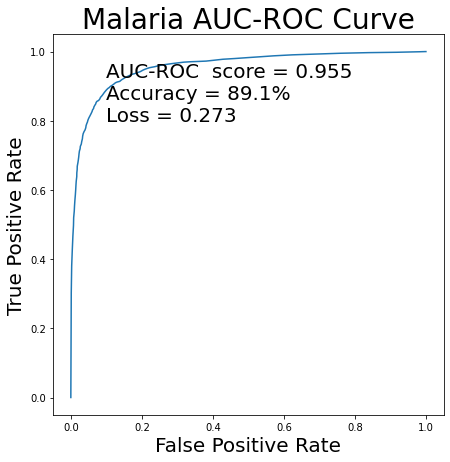

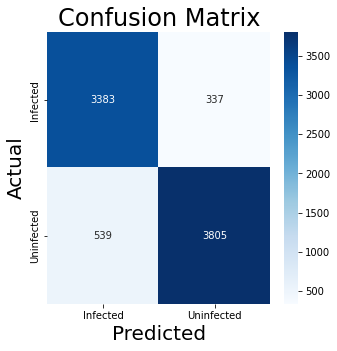

In [ ]:
def GetFalseTruePositiveRate1(y_true1,y_prob1,threshold):

    y_predict1 = np.fromiter([1 if x > threshold else 0 for x in y_prob1 ],int)
    n_positives1= y_true1.sum()
    n_negatives1 = y_true1.shape[0] - n_positives1

    # get n true positives
    n_true_pos1 = 0
    n_false_pos1 = 0
    for pred_value1,true_value1 in zip(y_predict1,y_true1):
        # true positive
        if true_value1 == 1 and pred_value1 == 1:
            n_true_pos1 += 1
        # false positive
        elif true_value1 == 0 and pred_value1 == 1:
            n_false_pos1 += 1
    true_pos_rate1 = n_true_pos1/n_positives1
    false_pos_rate1 = n_false_pos1/n_negatives1
    return false_pos_rate1,true_pos_rate1

def MakeConfusionMatrix1(y_true2,y_prob2,threshold):
    confusion_matrix2 = np.array([[0,0],[0,0]])
    for pred_value2,true_value2 in zip(y_prob2,y_true2):
        if true_value2 == 1:
            #true positive
            if pred_value2 > threshold:
                confusion_matrix2[0,0] += 1
            #false negative
            else:
                confusion_matrix2[1,0] += 1
        else:
            #false positive
            if pred_value2 > threshold:
                 confusion_matrix2[0,1] += 1
            #true negative
            else:
                confusion_matrix2[1,1] += 1
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix2,ax=ax,cmap='Blues',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title('Confusion Matrix',fontsize=24)
    plt.show()

y_predict2 = VGG.predict(X_test)
thresholds = np.arange(0.01,1.01,0.01)
thresholds = np.append(np.array([0,0.00001,0.0001,0.001]),thresholds)
roc_auc = np.array([GetFalseTruePositiveRate1(y_test,y_predict2,n) for n in thresholds ])
roc_auc = np.sort(roc_auc,axis=0)
roc_auc_value = roc_auc_score(y_test,y_predict2)
loss,accuracy = VGG.evaluate(X_test,y_test)
accuracy = accuracy
loss = loss
text = 'AUC-ROC  score = {:.3f}'.format(roc_auc_value)
text += '\nAccuracy = {:.1f}%'.format(accuracy*100)
text += '\nLoss = {:.3f}'.format(loss)

fig = plt.figure(figsize=(7,7))
ax =  fig.gca()
ax.set_title('Malaria AUC-ROC Curve',fontsize=28)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.plot(roc_auc[:,0],roc_auc[:,1])
ax.text(s=text,x=0.1, y=0.8,fontsize=20)
plt.show()

MakeConfusionMatrix1(y_test,y_predict2,0.5)


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers

In [ ]:

base_path = "/content/drive/MyDrive/cell-images-for-detecting-malaria/Training"
test_path = "/content/drive/MyDrive/ME/Cells"

In [ ]:
train_Uninfected= "/content/drive/MyDrive/cell-images-for-detecting-malaria/Training/Uninfected"
train_Parasitized= "/content/drive/MyDrive/cell-images-for-detecting-malaria/Training/Parasitized"

test_Uninfected= "/content/drive/MyDrive/ME/Cells/Uninfected"
test_Parasitized= "/content/drive/MyDrive/ME/Cells/Parasitized"

In [ ]:
# generating training set
print("training data :")
train_datagen= ImageDataGenerator(rescale=1/255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

train_data= train_datagen.flow_from_directory(base_path,
                                              target_size= (100,100),
                                              batch_size=20,
                                              class_mode= "binary",
                                              shuffle= True)


# generating validation set
print("\nvalidation data :")
val_datagen= ImageDataGenerator(rescale=1/255) # data augmentation is applied only to training data not to validation & test data

val_data= val_datagen.flow_from_directory(test_path,
                                          target_size= (100,100),
                                          batch_size=20,
                                          class_mode= "binary",
                                          shuffle= False)

# generating test set
print("\ntest data :")
test_datagen= ImageDataGenerator(rescale=1/255)

test_data= test_datagen.flow_from_directory(test_path,
                                            target_size= (100,100),
                                            batch_size=20,
                                            class_mode= "binary",
                                            shuffle= False)

training data :
Found 26880 images belonging to 2 classes.

validation data :
Found 15832 images belonging to 2 classes.

test data :
Found 15832 images belonging to 2 classes.


In [ ]:
train_data.class_indices


{'Parasitized': 0, 'Uninfected': 1}

In [ ]:

inception= InceptionV3(input_shape= (100, 100,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them
last_output= inception.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
inception_model= Model(inception.input, last_output)

In [ ]:
# layer 1
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
inc= Model(inception_model.input, x)

inc.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])
inc.summary()

In [ ]:
# Since the layers of InceptionV3 model are already trained, we don't want them to be trained again.
# So we will freeze these layers
for layer in inception_model.layers:
    layer.trainable= False

# fitting only Fully Connected layers
histor= inc.fit_generator(train_data,
                   steps_per_epoch= train_data.samples//train_data.batch_size,
                   validation_data= val_data,
                   validation_steps= val_data.samples//val_data.batch_size,
                   epochs=20, verbose= 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
accuracy = INC.evaluate(X_train , y_train)
print("Accuracy: ",accuracy)

336/336 [==============================] - 7s 18ms/step - loss: 0.4089 - binary_accuracy: 0.8481
Accuracy:  [0.40894967317581177, 0.8481212854385376]


In [ ]:
y = INC.predict(X_test)


252/252 [==============================] - 4s 17ms/step


In [ ]:
ccuracy = INC.evaluate(X_test , y_test)
print("Accuracy: ",accuracy)

252/252 [==============================] - 5s 18ms/step - loss: 0.4117 - binary_accuracy: 0.8455
Accuracy:  [0.40894967317581177, 0.8481212854385376]


252/252 [==============================] - 5s 18ms/step - loss: 0.4117 - binary_accuracy: 0.8455


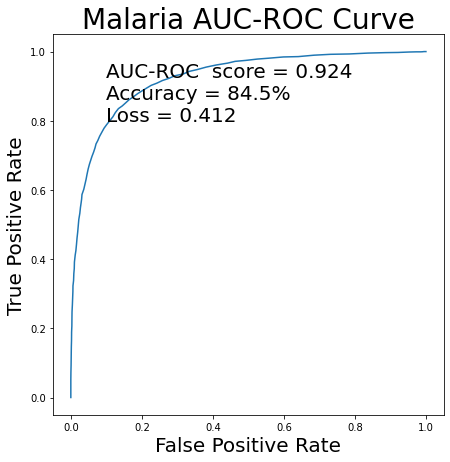

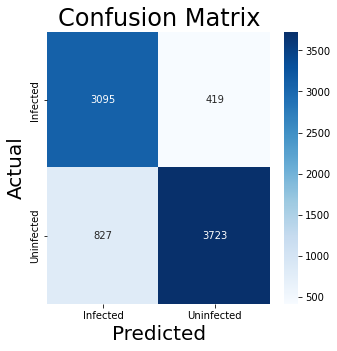

In [ ]:
def GetFalseTruePositiveRate1(y_true1,y_prob1,threshold):

    y_predict1 = np.fromiter([1 if x > threshold else 0 for x in y_prob1 ],int)
    n_positives1= y_true1.sum()
    n_negatives1 = y_true1.shape[0] - n_positives1

    # get n true positives
    n_true_pos1 = 0
    n_false_pos1 = 0
    for pred_value1,true_value1 in zip(y_predict1,y_true1):
        # true positive
        if true_value1 == 1 and pred_value1 == 1:
            n_true_pos1 += 1
        # false positive
        elif true_value1 == 0 and pred_value1 == 1:
            n_false_pos1 += 1
    true_pos_rate1 = n_true_pos1/n_positives1
    false_pos_rate1 = n_false_pos1/n_negatives1
    return false_pos_rate1,true_pos_rate1

def MakeConfusionMatrix1(y_true2,y_prob2,threshold):
    confusion_matrix2 = np.array([[0,0],[0,0]])
    for pred_value2,true_value2 in zip(y_prob2,y_true2):
        if true_value2 == 1:
            #true positive
            if pred_value2 > threshold:
                confusion_matrix2[0,0] += 1
            #false negative
            else:
                confusion_matrix2[1,0] += 1
        else:
            #false positive
            if pred_value2 > threshold:
                 confusion_matrix2[0,1] += 1
            #true negative
            else:
                confusion_matrix2[1,1] += 1
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix2,ax=ax,cmap='Blues',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title('Confusion Matrix',fontsize=24)
    plt.show()

y_predict2 = INC.predict(X_test)
thresholds = np.arange(0.01,1.01,0.01)
thresholds = np.append(np.array([0,0.00001,0.0001,0.001]),thresholds)
roc_auc = np.array([GetFalseTruePositiveRate1(y_test,y_predict2,n) for n in thresholds ])
roc_auc = np.sort(roc_auc,axis=0)
roc_auc_value = roc_auc_score(y_test,y_predict2)
loss,accuracy = VGG.evaluate(X_test,y_test)
accuracy = accuracy
loss = loss
text = 'AUC-ROC  score = {:.3f}'.format(roc_auc_value)
text += '\nAccuracy = {:.1f}%'.format(accuracy*100)
text += '\nLoss = {:.3f}'.format(loss)

fig = plt.figure(figsize=(7,7))
ax =  fig.gca()
ax.set_title('Malaria AUC-ROC Curve',fontsize=28)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.plot(roc_auc[:,0],roc_auc[:,1])
ax.text(s=text,x=0.1, y=0.8,fontsize=20)
plt.show()

MakeConfusionMatrix1(y_test,y_predict2,0.5)


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras import optimizers

In [ ]:
IMG_SHAPE = 100

cell_labels1 = []

# cells
cell_images1 = []

#first six infected and unfected cells for visualization only
infected_cells = []
uninfected_cells = []



In [ ]:
infected_path = base_path +'/Parasitized/'
for file in listdir(infected_path):
   if file.endswith('.png'):
        file_path = infected_path + file
        image = imageio.imread(file_path)
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0
        infected_cells.append(image)
        cell_images1.append(image)
        cell_labels1.append(1)


In [ ]:
#get uninfected cells
uninfected_path = base_path +'/Uninfected/'
for file in listdir(uninfected_path):
    if file.endswith('.png'):
        file_path = uninfected_path + file
        image = imageio.imread(file_path)
        image = cv2.resize(image,(IMG_SHAPE,IMG_SHAPE)).astype('float32')/255.0
        uninfected_cells.append(image)
        cell_images1.append(image)
        cell_labels1.append(0)

In [ ]:
#randomly shuffle cell image list and their labels
def reorder(old_list,order):
    new_list = []
    for i in order:
        new_list.append(old_list[i])
    return new_list

np.random.seed(seed=42)
indices = np.arange(len(cell_labels1))
np.random.shuffle(indices)
indices = indices.tolist()
cell_labels1 = reorder(cell_labels1,indices)
cell_images1 = reorder(cell_images1,indices)

#change to arrays
image_array1 = np.array(cell_images1)
label_array1 = np.array(cell_labels1)

In [ ]:
# 70% of the data goes to the training data set
X_train1, X_test1, y_train1, y_test1 = train_test_split(image_array1, label_array1, train_size=0.70, random_state=100)

# 30% additional data goes to the validation data set
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train1, y_train1, test_size=len(y_test), random_state=100)

print("size of training data set {}".format((X_train.shape[0])))
print("size of validating data set {}".format(X_val.shape[0]))
print("size of testing data set {}".format(X_test.shape[0]))


size of training data set 10752
size of validating data set 8064
size of testing data set 8064


In [ ]:

inception= InceptionV3(input_shape= (100, 100,3), include_top= False, weights="imagenet")

# Since we are creating our own fully connected layer we need output of the last inception model layer and flatten them
last_output= inception.layers[-1].output

# Flattening the last output
last_output= Flatten()(last_output)

# Our pretrained model
inception_model= Model(inception.input, last_output)

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
x= Dense(units=512, activation="relu")(last_output)
x=Dropout(0.2)(x)

# layer 2
x= Dense(units=128, activation="relu")(x)
x=Dropout(0.2)(x)

# output layer
x= Dense(units=1, activation="sigmoid")(x)

# final model
INC = Model(inception_model.input, x)

INC.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=1e-4), metrics=["accuracy"])
INC.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, acc, loss, val_acc, val_loss
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

callbacks_list = [early_stop, log_csv]

epochs = 20
batch_size =  32
history = INC.fit(X_train,y_train,
    steps_per_epoch=int(np.ceil(len(y_train)/ float(batch_size))),
    epochs=epochs,
    validation_data=(X_val,y_val),
    validation_steps=int(np.ceil(len(y_val) / float(batch_size))),
    callbacks=callbacks_list
)

Epoch 1/20


InvalidArgumentError: ignored

In [ ]:
for layer in inception_model.layers:
    layer.trainable= False

# fitting only Fully Connected layers
history= INC.fit(X_train,y_train,
                   steps_per_epoch= int(np.ceil(len(y_train)/ float(batch_size))),
                   validation_data=(X_val,y_val),
                   validation_steps= int(np.ceil(len(y_val) / float(batch_size))),
                   epochs=20, verbose= 2)

In [ ]:
accuracy = history.evaluate(X_train , y_train)
print("Accuracy: ",accuracy)

NameError: ignored

In [ ]:
y = INC.predict(X_test)


252/252 [==============================] - 4s 17ms/step


In [ ]:
ccuracy = INC.evaluate(X_test , y_test)
print("Accuracy: ",accuracy)

252/252 [==============================] - 5s 18ms/step - loss: 0.4117 - binary_accuracy: 0.8455


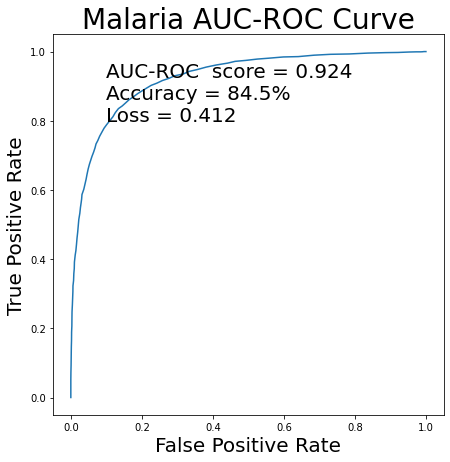

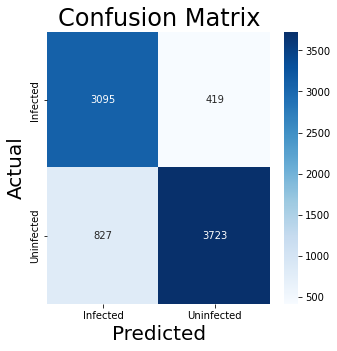

In [ ]:
def GetFalseTruePositiveRate1(y_true1,y_prob1,threshold):

    y_predict1 = np.fromiter([1 if x > threshold else 0 for x in y_prob1 ],int)
    n_positives1= y_true1.sum()
    n_negatives1 = y_true1.shape[0] - n_positives1

    # get n true positives
    n_true_pos1 = 0
    n_false_pos1 = 0
    for pred_value1,true_value1 in zip(y_predict1,y_true1):
        # true positive
        if true_value1 == 1 and pred_value1 == 1:
            n_true_pos1 += 1
        # false positive
        elif true_value1 == 0 and pred_value1 == 1:
            n_false_pos1 += 1
    true_pos_rate1 = n_true_pos1/n_positives1
    false_pos_rate1 = n_false_pos1/n_negatives1
    return false_pos_rate1,true_pos_rate1

def MakeConfusionMatrix1(y_true2,y_prob2,threshold):
    confusion_matrix2 = np.array([[0,0],[0,0]])
    for pred_value2,true_value2 in zip(y_prob2,y_true2):
        if true_value2 == 1:
            #true positive
            if pred_value2 > threshold:
                confusion_matrix2[0,0] += 1
            #false negative
            else:
                confusion_matrix2[1,0] += 1
        else:
            #false positive
            if pred_value2 > threshold:
                 confusion_matrix2[0,1] += 1
            #true negative
            else:
                confusion_matrix2[1,1] += 1
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix2,ax=ax,cmap='Blues',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title('Confusion Matrix',fontsize=24)
    plt.show()

y_predict2 = INC.predict(X_test)
thresholds = np.arange(0.01,1.01,0.01)
thresholds = np.append(np.array([0,0.00001,0.0001,0.001]),thresholds)
roc_auc = np.array([GetFalseTruePositiveRate1(y_test,y_predict2,n) for n in thresholds ])
roc_auc = np.sort(roc_auc,axis=0)
roc_auc_value = roc_auc_score(y_test,y_predict2)
loss,accuracy = VGG.evaluate(X_test,y_test)
accuracy = accuracy
loss = loss
text = 'AUC-ROC  score = {:.3f}'.format(roc_auc_value)
text += '\nAccuracy = {:.1f}%'.format(accuracy*100)
text += '\nLoss = {:.3f}'.format(loss)

fig = plt.figure(figsize=(7,7))
ax =  fig.gca()
ax.set_title('Malaria AUC-ROC Curve',fontsize=28)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=20)
ax.plot(roc_auc[:,0],roc_auc[:,1])
ax.text(s=text,x=0.1, y=0.8,fontsize=20)
plt.show()

MakeConfusionMatrix1(y_test,y_predict2,0.5)
